# Simulación Mundial Rusia 2018

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import itertools

# 1. Entrenamos el modelo KNN para luego predecir:

In [92]:
df_pre = pd.read_excel('TABLA_MODELO.xlsx', sheetname='PLANTILLA')

df_filt = df_pre[['ANIO', 
              'EQUIPO_1', 
              'RANKING_1', 
              'EQUIPO_2', 
              'RANKING_2',
              'POR_VIC1',
              'POR_VIC2',
              'ATAQUE_1',
              'MEDIO_1',
              'DEFENSA_1',
              'ATAQUE_2',
              'MEDIO_2',
              'DEFENSA_2',
              'RESULTADO_CUOTAS']]

df_filt['DIF_AT_DEF'] = df_filt['ATAQUE_1'] - df_filt['DEFENSA_2']
df_filt['DIF_MED'] = df_filt['MEDIO_1'] - df_filt['MEDIO_2']
df_filt['DIF_DEF_AT'] = df_filt['DEFENSA_1'] - df_filt['ATAQUE_2']
df_filt['DIF_RANK'] = df_filt['RANKING_2'] - df_filt['RANKING_1']
df_filt['DIF_VD_TRAN'] = df_filt['POR_VIC1'] - df_filt['POR_VIC2']
df_filt['RESULTADO'] = df_filt['RESULTADO_CUOTAS']

df = df_filt.copy()

#### Celda de elección de parámetros

In [93]:
anios = [2015, 2016, 2017, 2018]
tipo_partido = ['AMISTOSO', 'OFICIAL']
variables_modelo = ['DIF_AT_DEF', 'DIF_MED', 'DIF_DEF_AT', 'DIF_RANK', 'RESULTADO','DIF_VD_TRAN']
factor_variable1 = 10
factor_variable2 = 10
factor_variable3 = 10
factor_variable4 = 1
factor_variable5 = 1
testsize = 0.15

#### Tratamiento del dataframe

In [94]:
# Filtro de año

df = df[df['ANIO'].isin(anios)]

# Aplicación de factores de las variables

df[variables_modelo[0]] = df[variables_modelo[0]] * factor_variable1
df[variables_modelo[1]] = df[variables_modelo[1]] * factor_variable2
df[variables_modelo[2]] = df[variables_modelo[2]] * factor_variable3
df[variables_modelo[3]] = df[variables_modelo[3]] * factor_variable4
df[variables_modelo[4]] = df[variables_modelo[4]] * factor_variable5

# Nos quedamos con las columnas de las variables del modelo

df = df[variables_modelo]

df.head(5)

,DIF_AT_DEF,DIF_MED,DIF_DEF_AT,DIF_RANK,RESULTADO,DIF_VD_TRAN
0,140,130,140,66,1,0.571429
1,-50,-80,-100,-25,-1,-0.416667
2,-10,0,-20,1,0,-0.404762
3,0,-10,10,9,0,-0.261905
4,-30,-40,-60,-56,-1,-0.571429


#### Escalamos las variables

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.drop('RESULTADO',axis=1))
scaled_features = scaler.transform(df.drop('RESULTADO',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=df.columns[:-1])

#### Dividimos en train y test set

In [96]:
from sklearn.model_selection import train_test_split

X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(
                                                    scaled_features, 
                                                    df['RESULTADO'], 
                                                    test_size=testsize,
                                                    random_state=20)

####  Elegimos valor de K  -> Elbow method

Text(0,0.5,'Error Rate')

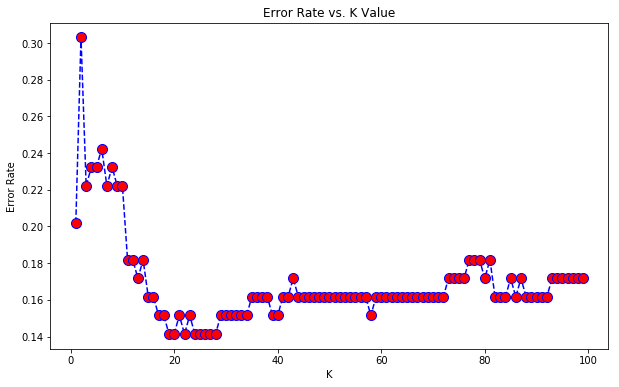

In [97]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []

for i in range(1,100):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_KNN,y_train_KNN)
    pred_i = knn.predict(X_test_KNN)
    error_rate.append(np.mean(pred_i != y_test_KNN))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

#### Entrenamos

In [98]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_KNN,y_train_KNN)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

#### Predecimos

In [99]:
predictions_KNN = knn.predict(X_test_KNN)

#### Performance

In [100]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test_KNN,predictions_KNN))

             precision    recall  f1-score   support

         -1       0.82      0.90      0.86        10
          0       0.83      0.90      0.87        50
          1       0.91      0.79      0.85        39

avg / total       0.86      0.86      0.86        99



In [101]:
cm = confusion_matrix(y_test_KNN,predictions_KNN)
accuracy = np.trace(cm)/np.sum(cm)
print("%.2f perc." %(accuracy*100))

85.86 perc.


# 2. Generamos para un partido la tabla de características

In [102]:
df1 = pd.read_excel('df1.xlsx')
tranchas_2 = pd.read_excel('tranchas_2.xlsx')

In [103]:
def trancha_ranking(ranking):
    if ranking <= 10:
        trancha = 1
    elif ranking <= 20:
        trancha = 2
    elif ranking <= 50:
        trancha = 3
    elif ranking <= 100:
        trancha = 4
    else:
        trancha = 5
    return trancha



In [104]:
def genera_tabla_caracteristicas(partido):
    
    local = df1[df1['Country'] == partido[0]]
    visitante = df1[df1['Country'] == partido[1]]

    union = pd.DataFrame()

    union['DIF_AT_DEF'] = pd.Series(int(local['Punt_Ataque']) - int(visitante['Punt_Def']))
    union['DIF_MED'] = pd.Series(int(local['Punt_Med']) - int(visitante['Punt_Med']))
    union['DIF_DEF_AT'] = pd.Series(int(local['Punt_Def']) - int(visitante['Punt_Ataque']))
    union['DIF_RANK'] = pd.Series(int(visitante['RANKING_FIFA']) - int(local['RANKING_FIFA']))
    
    ranking_local = int(tranchas_2[tranchas_2['EQUIPO'] == partido[0]]['RANKING_FIFA'][:1])
    trancha_local = trancha_ranking(ranking_local)

    ranking_visitante = int(tranchas_2[tranchas_2['EQUIPO'] == partido[1]]['RANKING_FIFA'][:1])
    trancha_visitante = trancha_ranking(ranking_visitante)
    
    cond1 = tranchas_2['EQUIPO'] == partido[0]
    cond2 = tranchas_2['TRANCHA'] == trancha_visitante

    porc_local = float(tranchas_2[cond1 & cond2]['POR_VIC'])

    cond3 = tranchas_2['EQUIPO'] == partido[1]
    cond4 = tranchas_2['TRANCHA'] == trancha_local

    porc_visitante = float(tranchas_2[cond3 & cond4]['POR_VIC'])

    union['DIF_VD_TRAN'] = pd.Series(porc_local - porc_visitante)

    return union

# 3. Definimos la función que predice el resultado de un partido

In [105]:
# En fase de grupos nos valen los empates

def predice_partido_con_empate(partido):
    
    tabla_caract = genera_tabla_caracteristicas(partido)
    caract_scaled = scaler.transform(tabla_caract)
    
    prediction_KNN = knn.predict(caract_scaled)
    
    prediccion_str = str(int(prediction_KNN))
    partido.append(prediccion_str)
    
    
    return partido

def predice_partido_sin_empate(partido):
    
    tabla_caract = genera_tabla_caracteristicas(partido)
    caract_scaled = scaler.transform(tabla_caract)
    
    prediction_KNN = knn.predict(caract_scaled)
    
    prediccion_str = str(int(prediction_KNN))
    
    prediccion_fin = prediccion_str
    
    if (prediccion_str == '0'):
        media_local = float(df1[df1['Country'] == partido[0]]['Punt_Media_Eq'])
        media_visitante = float(df1[df1['Country'] == partido[1]]['Punt_Media_Eq'])
        
        if media_local > media_visitante:
            prediccion_fin = '1'
        else:
            prediccion_fin = '-1'
            
    partido.append(prediccion_fin)

    
    return partido



# 4. Simulación del mundial

**Definimos funciones que utilizaremos:**

In [106]:
# Convertir una tabla en un diccionario

def df_to_dict(df):
    columns = df.columns
    d = dict(itertools.zip_longest(df[columns[0]], df[columns[1]]))
    return d

# Convertir un diccionario en una tabla

def dict_to_df(d):
    df = pd.DataFrame(columns=['Team', 'Points'])
    df['Team'] = d.keys()
    df['Points'] = d.values()
    return df

# Crea tablas de fase de grupos

def create_initial_table(list_teams):
    dict_teams = {list_teams[0]: 0,
                  list_teams[1]: 0, 
                  list_teams[2]: 0, 
                  list_teams[3]: 0}    
    df = dict_to_df(dict_teams)
    return df

# Actualiza tablas de fase de grupos

def update_group(df, result):
    d = df_to_dict(df)    
    if (result[0] not in list(d.keys()) or result[1] not in list(d.keys())):
        return 'Error: equipo no perteneciente a este grupo'
    
    elif (result[2] not in ['1', '-1', '0']):
        return 'Error: resultado incorrecto'    
    else:
        if result[2] == '1':
            winner = result[0]
            d[winner] +=3
        elif result[2] == '2':
            winner = result[1]
            d[winner] +=3    
        else:
            tie1 = result[0]
            tie2 = result[1]
            d[tie1] +=1
            d[tie2] +=1
        df = dict_to_df(d).sort_values(by= 'Points', ascending = False)
    return df


## Fase de grupos

Definimos los 8 grupos:

In [107]:
grupo_0 = ['ARABIA SAUDI','EGIPTO','URUGUAY', 'RUSIA']
grupo_1 = ['PORTUGAL', 'ESPANIA', 'MARRUECOS', 'IRAN']
grupo_2 = ['FRANCIA', 'AUSTRALIA', 'PERU', 'DINAMARCA']
grupo_3 = ['ARGENTINA', 'ISLANDIA', 'CROACIA', 'NIGERIA']
grupo_4 = ['BRASIL', 'SUIZA', 'COSTA RICA', 'SERBIA']
grupo_5 = ['ALEMANIA', 'MEXICO', 'SUECIA', 'REP. DE COREA']
grupo_6 = ['BELGICA', 'PANAMA', 'TUNEZ', 'INGLATERRA']
grupo_7 = ['POLONIA', 'SENEGAL', 'COLOMBIA', 'JAPON']


In [108]:
lista_grupos = [grupo_0, 
                grupo_1,
                grupo_2,
                grupo_3,
                grupo_4,
                grupo_5,
                grupo_6,
                grupo_7]

In [109]:
lista_grupos[1]

['PORTUGAL', 'ESPANIA', 'MARRUECOS', 'IRAN']

Simulamos los enfrentamientos:

In [110]:
todos_enfrentamientos = []

for i in np.arange(0,8):
    
    enfrentamiento = []
    
    enfrentamiento.append([lista_grupos[i][0],lista_grupos[i][1]])
    enfrentamiento.append([lista_grupos[i][0],lista_grupos[i][2]])
    enfrentamiento.append([lista_grupos[i][0],lista_grupos[i][3]])
    enfrentamiento.append([lista_grupos[i][1],lista_grupos[i][2]])
    enfrentamiento.append([lista_grupos[i][1],lista_grupos[i][3]])
    enfrentamiento.append([lista_grupos[i][2],lista_grupos[i][3]])


    
    todos_enfrentamientos.append(enfrentamiento)

In [111]:
todos_enfrentamientos[0]

[['ARABIA SAUDI', 'EGIPTO'],
 ['ARABIA SAUDI', 'URUGUAY'],
 ['ARABIA SAUDI', 'RUSIA'],
 ['EGIPTO', 'URUGUAY'],
 ['EGIPTO', 'RUSIA'],
 ['URUGUAY', 'RUSIA']]

En `todos_enfrentamientos` tenemos todos los enfrentamientos de la fase de grupos: todos_enfrentamientos[0] son los enfrentamientos del primer grupo, y `todos_enfrentamientos[0][0]` es el primer partido del primer grupo

Generamos una lista cuyos elementos son la tabla de cada grupo:

In [112]:
lista_tablas_grupos = []

for i in [grupo_0, 
          grupo_1, 
          grupo_2, 
          grupo_3, 
          grupo_4, 
          grupo_5, 
          grupo_6, 
          grupo_7]:
    
    df = create_initial_table(i)
    lista_tablas_grupos.append(df)

Simulamos la fase de grupos:

In [113]:
resultado_fase_grupos = []

i = 0

for grupo in todos_enfrentamientos:
    
    
    resultado_fase_grupos.append(lista_tablas_grupos[i])
    
    for partido in grupo:
    
        resultado = predice_partido_con_empate(partido)
        tabla = update_group(resultado_fase_grupos[-1],resultado)
        resultado_fase_grupos.append(tabla)
    i +=1

El resultado de los grupos es: `resultado_fase_grupos`:

`[6, 13, 20, 27, 34, 41, 48, 55]`



In [200]:
resultado_fase_grupos[54]

,Team,Points
0,POLONIA,7
1,COLOMBIA,2
2,SENEGAL,2
3,JAPON,1


In [201]:
resultado_fase_grupos[55]

,Team,Points
0,POLONIA,7
1,COLOMBIA,5
2,SENEGAL,2
3,JAPON,1


#### Resultado grupo A

In [54]:
res_grupo_A = resultado_fase_grupos[6]
res_grupo_A

,Team,Points
2,URUGUAY,5
0,ARABIA SAUDI,3
1,EGIPTO,3
3,RUSIA,2


#### Resultado grupo B

In [55]:
res_grupo_B = resultado_fase_grupos[13]
res_grupo_B

,Team,Points
0,PORTUGAL,5
1,ESPANIA,5
2,IRAN,3
3,MARRUECOS,1


#### Resultado grupo C

In [56]:
res_grupo_C = resultado_fase_grupos[20]
res_grupo_C

,Team,Points
0,FRANCIA,9
1,AUSTRALIA,2
2,PERU,2
3,DINAMARCA,2


#### Resultado grupo D

In [57]:
res_grupo_D = resultado_fase_grupos[27]
res_grupo_D

,Team,Points
2,CROACIA,5
0,ARGENTINA,3
1,ISLANDIA,3
3,NIGERIA,2


#### Resultado grupo E

In [58]:
res_grupo_E = resultado_fase_grupos[34]
res_grupo_E

,Team,Points
0,BRASIL,7
1,SUIZA,3
2,COSTA RICA,2
3,SERBIA,2


#### Resultado grupo F

In [59]:
res_grupo_F = resultado_fase_grupos[41]
res_grupo_F

,Team,Points
0,ALEMANIA,5
1,MEXICO,5
2,SUECIA,3
3,REP. DE COREA,1


#### Resultado grupo G

In [60]:
res_grupo_G = resultado_fase_grupos[48]
res_grupo_G

,Team,Points
0,BELGICA,7
1,INGLATERRA,3
2,PANAMA,2
3,TUNEZ,2


#### Resultado grupo H

In [61]:
res_grupo_H = resultado_fase_grupos[55]
res_grupo_H

,Team,Points
0,POLONIA,7
1,COLOMBIA,5
2,SENEGAL,2
3,JAPON,1


En caso de empates, pasa el de mayor media:

In [62]:
# Metemos todas las tablas de grupos en una lista

lista_tablas2 = [res_grupo_A, 
                 res_grupo_B, 
                 res_grupo_C, 
                 res_grupo_D,
                 res_grupo_E, 
                 res_grupo_F, 
                 res_grupo_G, 
                 res_grupo_H,]

In [63]:
aux_desempate = df1[['Country', 'Punt_Media_Eq']]
lista3 = []

for grupo in lista_tablas2:
    grupo_desemp = grupo.merge(aux_desempate, 
                                       left_on='Team', 
                                       right_on='Country', 
                                       how='inner').drop('Country', axis=1)
    grupo_desemp_2 = grupo_desemp.sort_values(by=['Points', 'Punt_Media_Eq'], ascending=False)
    lista3.append(grupo_desemp_2)

Los grupos quedan:

#### Resultado definitivo grupo A

In [64]:
lista3[0]

,Team,Points,Punt_Media_Eq
0,URUGUAY,5,81.000000
2,EGIPTO,3,76.000000
1,ARABIA SAUDI,3,71.333333
3,RUSIA,2,77.000000


#### Resultado definitivo grupo B

In [65]:
lista3[1]

,Team,Points,Punt_Media_Eq
1,ESPANIA,5,85.000000
0,PORTUGAL,5,84.333333
2,IRAN,3,73.000000
3,MARRUECOS,1,76.000000


#### Resultado definitivo grupo C

In [66]:
lista3[2]

,Team,Points,Punt_Media_Eq
0,FRANCIA,9,84.000000
3,DINAMARCA,2,76.666667
2,PERU,2,75.666667
1,AUSTRALIA,2,70.666667


#### Resultado definitivo grupo D

In [67]:
lista3[3]

,Team,Points,Punt_Media_Eq
0,CROACIA,5,80.333333
1,ARGENTINA,3,83.333333
2,ISLANDIA,3,76.000000
3,NIGERIA,2,74.333333


#### Resultado definitivo grupo E

In [68]:
lista3[4]

,Team,Points,Punt_Media_Eq
0,BRASIL,7,86.000000
1,SUIZA,3,77.000000
3,SERBIA,2,77.666667
2,COSTA RICA,2,71.666667


#### Resultado definitivo grupo F

In [69]:
lista3[5]

,Team,Points,Punt_Media_Eq
0,ALEMANIA,5,85.0
1,MEXICO,5,79.0
2,SUECIA,3,77.0
3,REP. DE COREA,1,71.0


#### Resultado definitivo grupo G

In [70]:
lista3[6]

,Team,Points,Punt_Media_Eq
0,BELGICA,7,83.666667
1,INGLATERRA,3,81.666667
3,TUNEZ,2,71.333333
2,PANAMA,2,68.666667


#### Resultado definitivo grupo H

In [71]:
lista3[7]

,Team,Points,Punt_Media_Eq
0,POLONIA,7,79.666667
1,COLOMBIA,5,79.333333
2,SENEGAL,2,76.666667
3,JAPON,1,75.333333


16:00 1C - 2D (50) (Kazan)

20:00 1A - 2B (49) (Sochi)

16:00 1B - 2A (51) (Moscú Luzhniki)

20:00 1D - 2C (52) (Nizhny Novgorod)

16:00 1E - 2F (53) (Samara)

20:00 1G - 2H (54) (Rostov)

16:00 1F - 2E (55) (San Petersburgo)

20:00 1H - 2G (56) (Moscú Spartak)

## Octavos

In [72]:
octavos_50 = [lista3[2]['Team'].iloc[0], lista3[3]['Team'].iloc[1]]
octavos_49 = [lista3[0]['Team'].iloc[0], lista3[1]['Team'].iloc[1]]
octavos_51 = [lista3[1]['Team'].iloc[0], lista3[0]['Team'].iloc[1]]
octavos_52 = [lista3[3]['Team'].iloc[0], lista3[2]['Team'].iloc[1]]
octavos_53 = [lista3[4]['Team'].iloc[0], lista3[5]['Team'].iloc[1]]
octavos_54 = [lista3[6]['Team'].iloc[0], lista3[7]['Team'].iloc[1]]
octavos_55 = [lista3[5]['Team'].iloc[0], lista3[4]['Team'].iloc[1]]
octavos_56 = [lista3[7]['Team'].iloc[0], lista3[6]['Team'].iloc[1]]

Los partidos de octavos son:

In [73]:
print(octavos_50)
print(octavos_49)
print(octavos_51)
print(octavos_52)
print(octavos_53)
print(octavos_54)
print(octavos_55)
print(octavos_56)

['FRANCIA', 'ARGENTINA']
['URUGUAY', 'PORTUGAL']
['ESPANIA', 'EGIPTO']
['CROACIA', 'DINAMARCA']
['BRASIL', 'MEXICO']
['BELGICA', 'COLOMBIA']
['ALEMANIA', 'SUIZA']
['POLONIA', 'INGLATERRA']


In [74]:
partidos_octavos = [octavos_50,
                     octavos_49,
                     octavos_51,
                     octavos_52,
                     octavos_53,
                     octavos_54,
                     octavos_55,
                     octavos_56]

resultados_octavos = []

for partido in partidos_octavos:
    resultado = predice_partido_sin_empate(partido)
    if resultado[2] == '1':
        resultados_octavos.append(resultado[0])
    elif resultado[2] == '-1':
        resultados_octavos.append(resultado[1])
    else:
        resultados_octavos.append('EMPATE')
    

In [75]:
resultados_octavos

['FRANCIA',
 'PORTUGAL',
 'ESPANIA',
 'CROACIA',
 'BRASIL',
 'BELGICA',
 'ALEMANIA',
 'INGLATERRA']

## Cuartos 

Ganador 49 - Ganador 50 (57) (Nizhny Novgorod)

Ganador 53 - Ganador 54 (58) (Kazan)

Ganador 55 - Ganador 56 (60) (Samara)

Ganador 51 - Ganador 52 (59) (Sochi)

Los partidos de cuartos son:

In [76]:
cuartos_57 = [resultados_octavos[0], resultados_octavos[1]]
cuartos_58 = [resultados_octavos[4], resultados_octavos[5]]
cuartos_60 = [resultados_octavos[6], resultados_octavos[7]]
cuartos_59 = [resultados_octavos[2], resultados_octavos[3]]

In [77]:
print(cuartos_57)
print(cuartos_58)
print(cuartos_60)
print(cuartos_59)

['FRANCIA', 'PORTUGAL']
['BRASIL', 'BELGICA']
['ALEMANIA', 'INGLATERRA']
['ESPANIA', 'CROACIA']


In [78]:
partidos_cuartos = [cuartos_57,
                     cuartos_58,
                     cuartos_60,
                     cuartos_59]

resultados_cuartos = []

for partido in partidos_cuartos:
    resultado = predice_partido_sin_empate(partido)
    if resultado[2] == '1':
        resultados_cuartos.append(resultado[0])
    elif resultado[2] == '-1':
        resultados_cuartos.append(resultado[1])
    else:
        resultados_cuartos.append('EMPATE')
    

In [79]:
resultados_cuartos

['PORTUGAL', 'BRASIL', 'ALEMANIA', 'ESPANIA']

## Semis

Martes 10 julio: 20.00 h (18.00 GMT): Ganador 57 - Ganador 58 (61). Zenit Arena San Petersburgo

Miércoles 11 julio: 20.00 h (18.00 GMT): Ganador 59 - Ganador 60 (62). Luzhniki Stadium Moscú

Los partidos de semis son:

In [80]:
semis_61 = [resultados_cuartos[0], resultados_cuartos[1]]
semis_62 = [resultados_cuartos[2], resultados_cuartos[3]]

In [81]:
partidos_semis = [semis_61,
                  semis_62]

resultados_semis = []
terc_cuart_puesto = []

for partido in partidos_semis:
    resultado = predice_partido_sin_empate(partido)
    if resultado[2] == '1':
        resultados_semis.append(resultado[0])
        terc_cuart_puesto.append(resultado[1])
    elif resultado[2] == '-1':
        resultados_semis.append(resultado[1])
        terc_cuart_puesto.append(resultado[0])
    else:
        resultados_semis.append('EMPATE')
    

In [82]:
resultados_semis

['BRASIL', 'ESPANIA']

In [83]:
terc_cuart_puesto

['PORTUGAL', 'ALEMANIA']

## Final

In [84]:
final = predice_partido_sin_empate(resultados_semis)
final

['BRASIL', 'ESPANIA', '1']

In [85]:
if final[2] == '1':
    ganador_mundial = final[0]
    segundo_puesto = final[1]
else: 
    ganador_mundial = final[1]
    segundo_puesto = final[0]

## Tercer y cuarto puesto

In [86]:
terc_cuart_p = predice_partido_sin_empate(terc_cuart_puesto)
terc_cuart_p

['PORTUGAL', 'ALEMANIA', '-1']

In [87]:
if terc_cuart_p[2] == '1':
    tercer_puesto = terc_cuart_p[0]
    cuarto_puesto = terc_cuart_p[1]
else: 
    tercer_puesto = terc_cuart_p[1]
    cuarto_puesto = terc_cuart_p[0]

In [88]:
print("El ganador del mundial es: %s " %ganador_mundial)
print("El segundo clasificado es: %s " %segundo_puesto)
print("El tercer clasificado es: %s " %tercer_puesto)
print("El cuarto clasificado es: %s " %cuarto_puesto)



El ganador del mundial es: BRASIL 
El segundo clasificado es: ESPANIA 
El tercer clasificado es: ALEMANIA 
El cuarto clasificado es: PORTUGAL 


# 5. Resultado

Para elegir los puestos 8, 16 y 32:

* 32: el peor equipo de la fase de grupos. Si hay empates, el que mayor diferencia de promedios tenga respecto al resto de equipos es el peor.

**32 clasificado**: **REP. DE COREA**

* 16: de los 8 equipos que han perdido en octavos, el que menos puntos tenga en fase de grupos. Si hay empates, el que mayor diferencia de promedios tenga respecto al resto de equipos es el peor.

**16 clasificado: EGIPTO**


* 8: de los 4 equipos que han perdido en cuartos, el que menos puntos tenga en fase de grupos. Si hay empates, el que mayor diferencia de promedios tenga respecto al resto de equipos es el peor.

**8 clasificado: DINAMARCA **

**4 clasificado: PORTUGAL **

**3 clasificado: ALEMANIA **

**2 clasificado: ESPAÑA **

**Ganador: BRASIL **